<a href="https://colab.research.google.com/github/Ptuancuong/TH-TimeSeries.csv/blob/main/ThucHanh03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
a = (2251262584%15+1)
a

5

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
df = pd.read_csv('/content/monthly_csv.csv')
df.head(10)

,Source,Date,Mean
0,GCAG,2016-12-06,0.7895
1,GISTEMP,2016-12-06,0.8100
2,GCAG,2016-11-06,0.7504
3,GISTEMP,2016-11-06,0.9300
4,GCAG,2016-10-06,0.7292
5,GISTEMP,2016-10-06,0.8900
6,GCAG,2016-09-06,0.8767
7,GISTEMP,2016-09-06,0.8700
8,GCAG,2016-08-06,0.8998
9,GISTEMP,2016-08-06,0.9800


In [ ]:
!pip install scikit-learn pandas matplotlib seaborn torch transformers


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 103.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 78.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 84.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Chọn nguồn GCAG và sắp xếp theo thời gian
df['Date'] = pd.to_datetime(df['Date'])
gcag = df[df['Source'] == 'GCAG'].sort_values('Date')

# Chuẩn hóa
scaler = StandardScaler()
gcag['Mean_scaled'] = scaler.fit_transform(gcag[['Mean']])


In [ ]:
import numpy as np

# Hàm tạo sliding window
def create_sequences(data, window_size):
    sequences = []
    for i in range(len(data) - window_size):
        sequences.append(data[i:i + window_size])
    return np.array(sequences)

window_size = 12  # 12 tháng
sequences = create_sequences(gcag['Mean_scaled'].values, window_size)


In [ ]:
import torch
from torch import nn

class SimpleTransformer(nn.Module):
    def __init__(self, input_dim, model_dim, nhead, num_layers):
        super().__init__()
        self.embedding = nn.Linear(input_dim, model_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=model_dim, nhead=nhead)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.output = nn.Linear(model_dim, model_dim)

    def forward(self, x):
        x = self.embedding(x)
        x = self.transformer(x)
        x = self.output(x.mean(dim=1))  # dùng mean pooling
        return x

# Khởi tạo
model = SimpleTransformer(input_dim=1, model_dim=16, nhead=2, num_layers=2)
inputs = torch.tensor(sequences[..., np.newaxis], dtype=torch.float32)
with torch.no_grad():
    transformed_features = model(inputs).numpy()


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


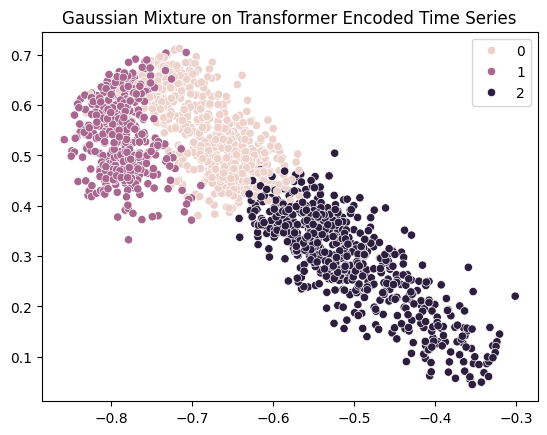

In [ ]:
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import seaborn as sns

# Chạy GMM
gmm = GaussianMixture(n_components=3, random_state=0)
labels = gmm.fit_predict(transformed_features)

# Vẽ kết quả
sns.scatterplot(x=transformed_features[:,0], y=transformed_features[:,1], hue=labels)
plt.title("Gaussian Mixture on Transformer Encoded Time Series")
plt.show()
